### 1. Путь к успеху.

Поиграйтесь с параметрами последней модели (количество нейронов, количество слоёв, вероятность dropout, количество эпох), чтобы получить Accuracy 98.5+%.


In [ ]:
import torch # 5 GB! Plus we'll need GPU later (probably)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders for stochastic gradient descent
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

Определение модели


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

## TODO: Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # linear layer (784 -> 1 hidden node)
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 100)
        self.fc5 = nn.Linear(100, 50)
        self.dropout = nn.Dropout(p=0.1) # google it

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=50, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


Обучение

In [ ]:
## TODO: Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) # Try lr=0.05 and n_epochs=1

# number of epochs to train the model
n_epochs = 50  # suggest training between 20-50 epochs

model.train() # prep model for training (enables dropout)

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)

    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

Epoch: 1 	Training Loss: 0.015066
Epoch: 2 	Training Loss: 0.015836
Epoch: 3 	Training Loss: 0.015098
Epoch: 4 	Training Loss: 0.012993
Epoch: 5 	Training Loss: 0.014666
Epoch: 6 	Training Loss: 0.010467
Epoch: 7 	Training Loss: 0.010794
Epoch: 8 	Training Loss: 0.008617
Epoch: 9 	Training Loss: 0.005979
Epoch: 10 	Training Loss: 0.009263
Epoch: 11 	Training Loss: 0.008129
Epoch: 12 	Training Loss: 0.006006
Epoch: 13 	Training Loss: 0.007733
Epoch: 14 	Training Loss: 0.005404
Epoch: 15 	Training Loss: 0.005813
Epoch: 16 	Training Loss: 0.007260
Epoch: 17 	Training Loss: 0.005740
Epoch: 18 	Training Loss: 0.005955
Epoch: 19 	Training Loss: 0.004207
Epoch: 20 	Training Loss: 0.007380
Epoch: 21 	Training Loss: 0.005606
Epoch: 22 	Training Loss: 0.004979
Epoch: 23 	Training Loss: 0.003140
Epoch: 24 	Training Loss: 0.003799
Epoch: 25 	Training Loss: 0.004494
Epoch: 26 	Training Loss: 0.005127
Epoch: 27 	Training Loss: 0.003250
Epoch: 28 	Training Loss: 0.003305
Epoch: 29 	Training Loss: 0.0

Тест

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100. * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.083959

Test Accuracy of     0: 99% (974/980)
Test Accuracy of     1: 99% (1131/1135)
Test Accuracy of     2: 98% (1016/1032)
Test Accuracy of     3: 97% (988/1010)
Test Accuracy of     4: 97% (962/982)
Test Accuracy of     5: 98% (876/892)
Test Accuracy of     6: 98% (941/958)
Test Accuracy of     7: 98% (1012/1028)
Test Accuracy of     8: 98% (959/974)
Test Accuracy of     9: 98% (995/1009)

Test Accuracy (Overall): 98% (9854/10000)


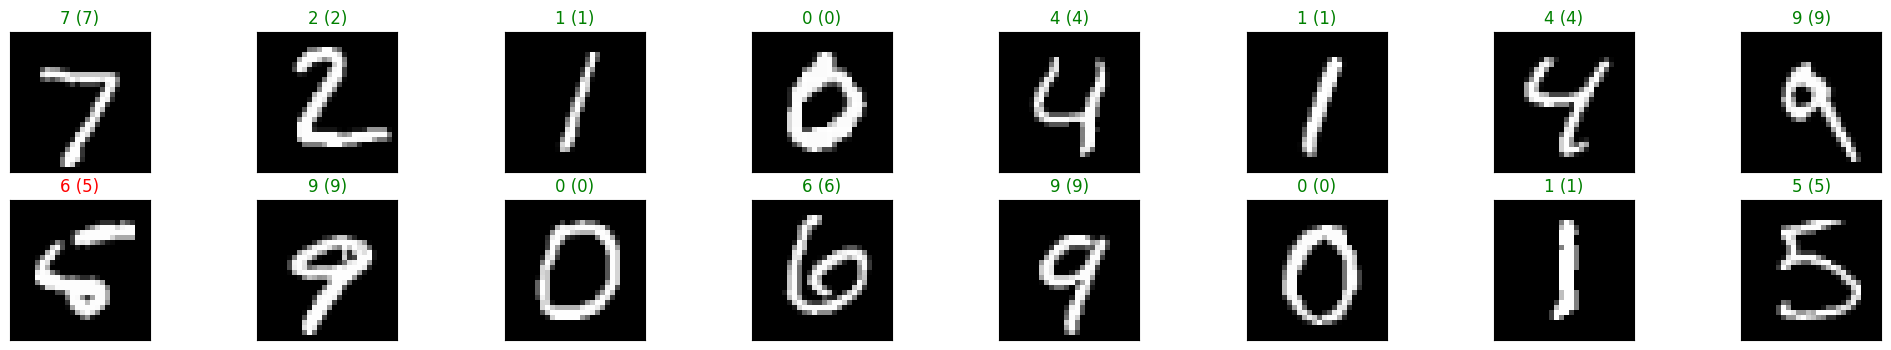

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

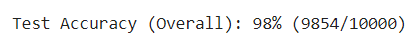



Можно сказать, что это больше $98,5433\%$



2. Метрики качества.
Для любой из цифр постройте confusion matrix итоговой модели. Определите accuracy, precison и recall в классификации этой цифры.

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100. * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.047941

Test Accuracy of     0:  0% ( 0/ 1)
Test Accuracy of     1:  0% ( 0/ 2)
Test Accuracy of     2: 50% ( 1/ 2)
Test Accuracy of     3:  0% ( 0/ 2)
Test Accuracy of     4:  0% ( 0/ 2)
Test Accuracy of     5:  0% ( 0/ 2)
Test Accuracy of     6:  0% ( 0/ 2)
Test Accuracy of     7:  0% ( 0/ 1)
Test Accuracy of     8:  0% ( 0/ 1)
Test Accuracy of     9:  0% ( 0/ 1)

Test Accuracy (Overall):  6% ( 1/16)
